In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [ ]:
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
import xgboost as xg
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import missingno as msno

import optuna

# import pandas_profiling as pp

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [ ]:
# pp.ProfileReport(train)

When we look at this, we can see that "Utilities" and "Street" and so on consist of almost the same variables. It seems to be almost useless for analysis.<br>Later, we address on this problem.

In [ ]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

### Missing Train values

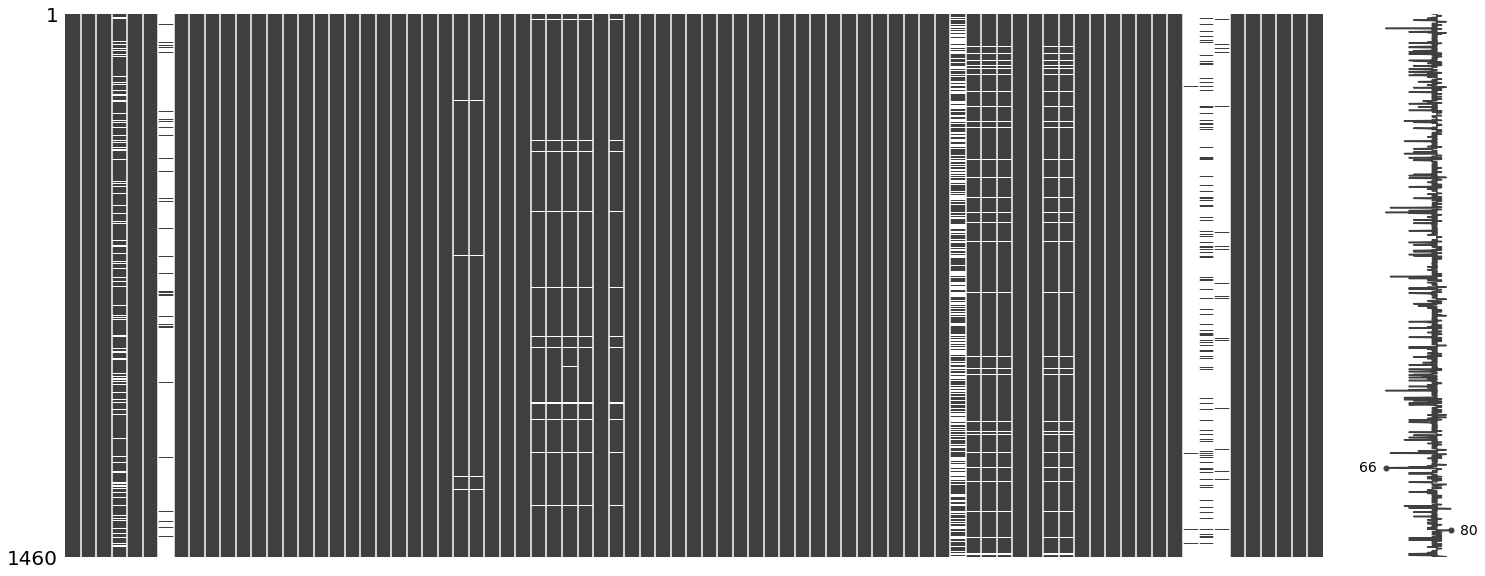

In [ ]:
msno.matrix(train);

In [ ]:
total = train.isnull().sum().sort_values(ascending = False)[train.isnull().sum().sort_values(ascending = False) != 0]
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)[(train.isnull().sum() / train.isnull().count()).sort_values(ascending = False) != 0]
missing = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
print(missing)

              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685


In [ ]:
def plotting_3_chart(df, feature):
    style.use("fivethirtyeight")

    fig = plt.figure(constrained_layout = True, figsize = (15, 8))#constrained_layout:auto adjust object placement.
    grid = gridspec.GridSpec(ncols = 3, nrows = 2, figure = fig)

    #Histogram
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature], norm_hist = True, ax = ax1, color = 'g')

    #Probability Plot
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Probability Plot')
    stats.probplot(df.loc[:, feature], plot = ax2)

    #Box Plot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:, feature], orient = 'v', ax = ax3)

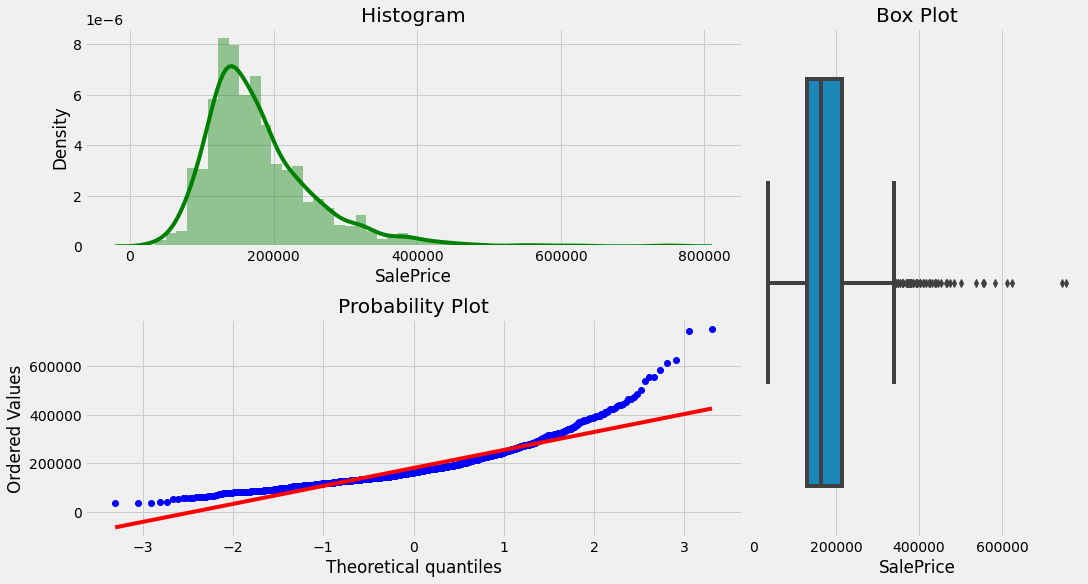

In [ ]:
plotting_3_chart(train, 'SalePrice')

<ul>
<li>Out target variable, <b>SalePrice</b> is not normally distributed.
<li>Our target variable is right-skewed.
<li>There are multiple outliers in the variable.
</ul>

It looks like there are quite a bit Skewness and Kurtosis in the target variable. Let's talk about those a bit.

<b>Skewness</b>
* is the degree of distortion from the symmetrical bell curve or the normal curve.
* So, a symmetrical distribution will have a skewness of "0".
* There are two types of Skewness: <b>Positive and Negative.</b>
* <b>Positive Skewness</b>(similar to our target variable distribution) means the tail on the right side of the distribution is longer and fatter.
* In <b>positive Skewness </b> the mean and median will be greater than the mode similar to this dataset. Which means more houses were sold by less than the average price.
* <b>Negative Skewness</b> means the tail on the left side of the distribution is longer and fatter.
* In <b>negative Skewness </b> the mean and median will be less than the mode.
* Skewness differentiates in extreme values in one versus the other tail.

Here is a picture to make more sense.  
![image](https://cdn-images-1.medium.com/max/1600/1*nj-Ch3AUFmkd0JUSOW_bTQ.jpeg)

In [ ]:
print("Skewness: ", train['SalePrice'].skew())

Skewness:  1.8828757597682129


**Kurtosis**<br>

According to Wikipedia,

*In probability theory and statistics, **Kurtosis** is the measure of the "tailedness" of the probability. distribution of a real-valued random variable.* So, In other words, **it is the measure of the extreme values(outliers) present in the distribution.**

* There are three types of Kurtosis: <b>Mesokurtic, Leptokurtic, and Platykurtic</b>.
* Mesokurtic is similar to the normal curve with the standard value of 3. This means that the extreme values of this distribution are similar to that of a normal distribution.
* Leptokurtic: Example of leptokurtic distributions are the T-distributions with small degrees of freedom.
* Platykurtic: Platykurtic describes a particular statistical distribution with thinner tails than a normal distribution. Because this distribution has thin tails, it has fewer outliers (e.g., extreme values three or more standard deviations from the mean) than do mesokurtic and leptokurtic distributions.

![image](https://i2.wp.com/mvpprograms.com/help/images/KurtosisPict.jpg?resize=375%2C234)


You can read more about this from [this](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa) article.

In [ ]:
print('kurtosis: ', train['SalePrice'].kurt())

kurtosis:  6.536281860064529


We can fix this by using different types of transformation(more on this later). However, before doing that, I want to find out the relationships among the target variable and other predictor variables. Let's find out.

In [ ]:
(train.corr()**2)['SalePrice'].sort_values(ascending = False)#.index[:5]

SalePrice        1.000000
OverallQual      0.625652
GrLivArea        0.502149
GarageCars       0.410124
GarageArea       0.388667
TotalBsmtSF      0.376481
1stFlrSF         0.367057
FullBath         0.314344
TotRmsAbvGrd     0.284860
YearBuilt        0.273422
YearRemodAdd     0.257151
GarageYrBlt      0.236548
MasVnrArea       0.228000
Fireplaces       0.218023
BsmtFinSF1       0.149320
LotFrontage      0.123763
WoodDeckSF       0.105244
2ndFlrSF         0.101974
OpenPorchSF      0.099765
HalfBath         0.080717
LotArea          0.069613
BsmtFullBath     0.051585
BsmtUnfSF        0.046001
BedroomAbvGr     0.028296
KitchenAbvGr     0.018471
EnclosedPorch    0.016532
ScreenPorch      0.012420
PoolArea         0.008538
MSSubClass       0.007104
OverallCond      0.006062
MoSold           0.002156
3SsnPorch        0.001988
YrSold           0.000837
LowQualFinSF     0.000656
Id               0.000480
MiscVal          0.000449
BsmtHalfBath     0.000284
BsmtFinSF2       0.000129
Name: SalePr

These are the predictor variables sorted in a descending order starting with the most correlated one <b>OverallQual</b>. <br>Let's put these in a scatter plot and check how it looks.

#### SalePrice vs OverallQual

In [ ]:
def customized_scatterplot(y, x):
    style.use('fivethirtyeight')
    plt.subplots(figsize = (12, 8))
    sns.scatterplot(y = y, x = x)

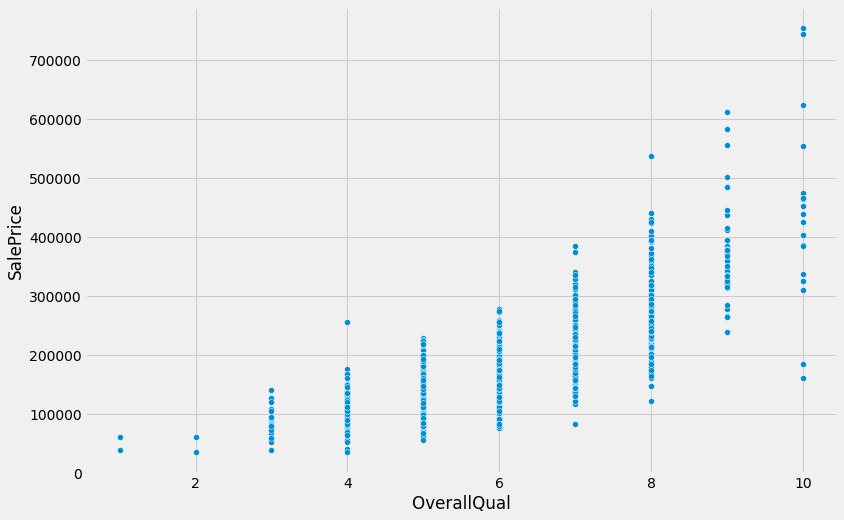

In [ ]:
customized_scatterplot(train.SalePrice, train.OverallQual)

Because OverallQual is categorical variable, so scatter plot is not suitable. But it is certain that there is a relationship between the two variables.<br>Let's check other variables.

#### SalePrice vs GvLivArea

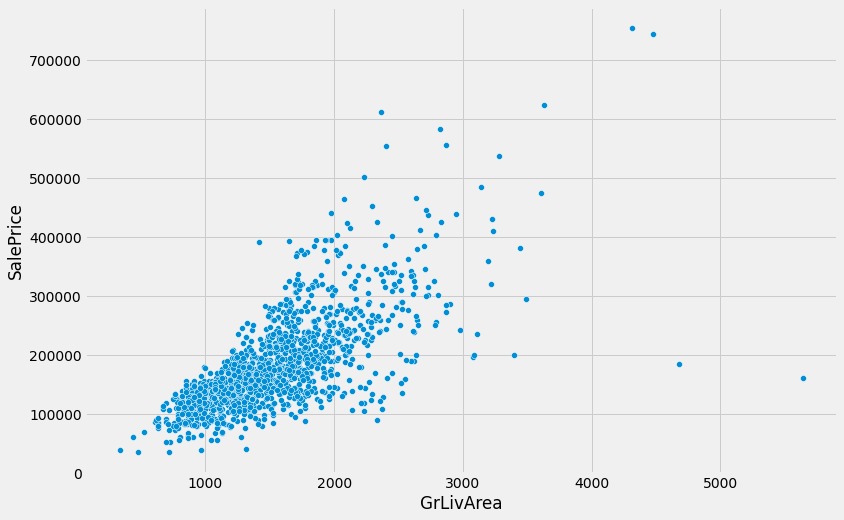

In [ ]:
customized_scatterplot(train.SalePrice, train.GrLivArea)

#### SalePrice vs GarageArea

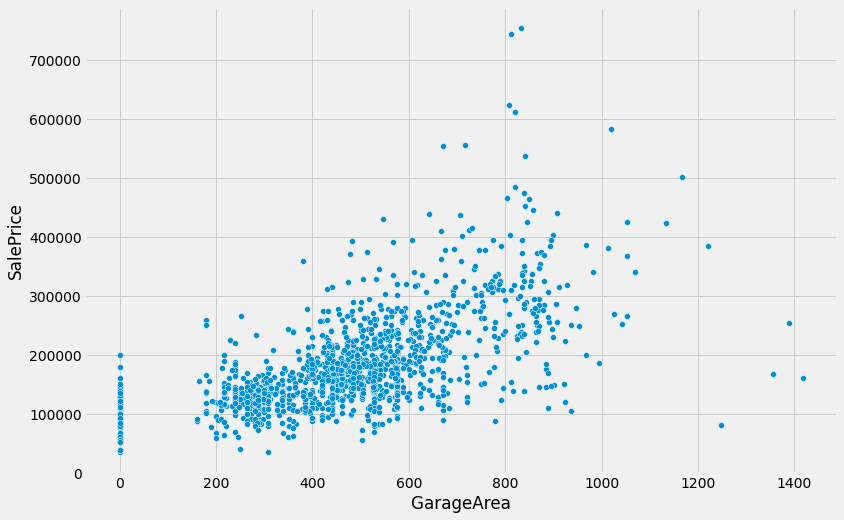

In [ ]:
customized_scatterplot(train.SalePrice, train.GarageArea)

#### SalePrice vs TotalBsmtSF

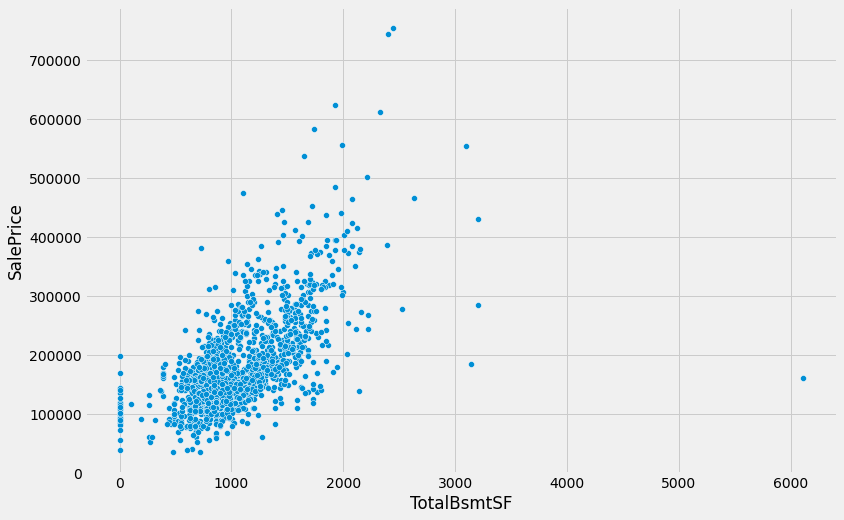

In [ ]:
customized_scatterplot(train.SalePrice, train.TotalBsmtSF)

#### SalePrice vs 1stFlrSF

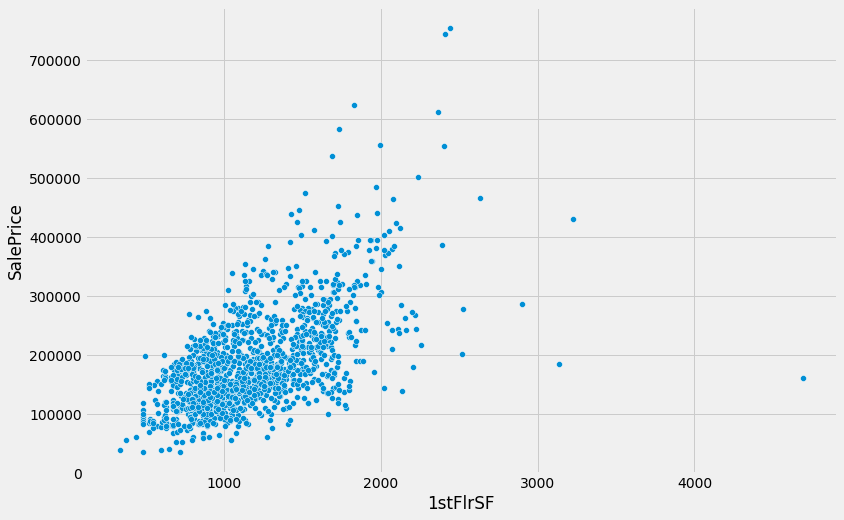

In [ ]:
customized_scatterplot(train.SalePrice, train['1stFlrSF'])

#### SalePrice vs MasVnrArea

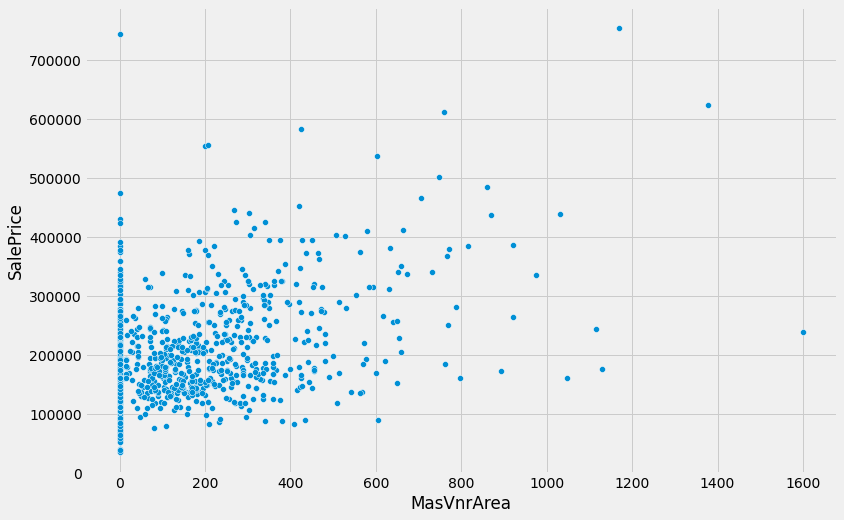

In [ ]:
customized_scatterplot(train.SalePrice, train.MasVnrArea)

There are multiple outliers in some figures. We'll address this problem later.

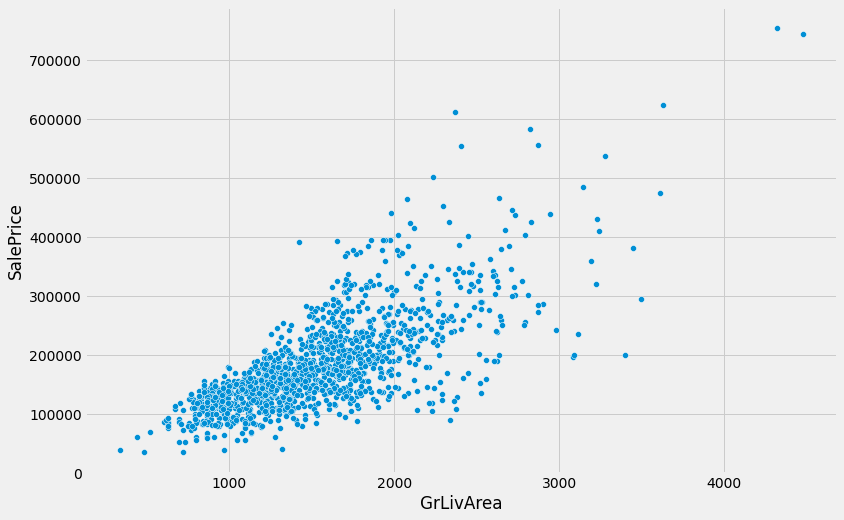

In [ ]:
train_ = train[train.GrLivArea < 4500]
train_.reset_index(drop = True, inplace = True)
previous_train = train_.copy()
customized_scatterplot(train_.SalePrice, train_.GrLivArea)

The two on the top-right edge of above figure seem to follow a trend, which can be explained by saying that "As the prices increased, this did too", so we leave this.

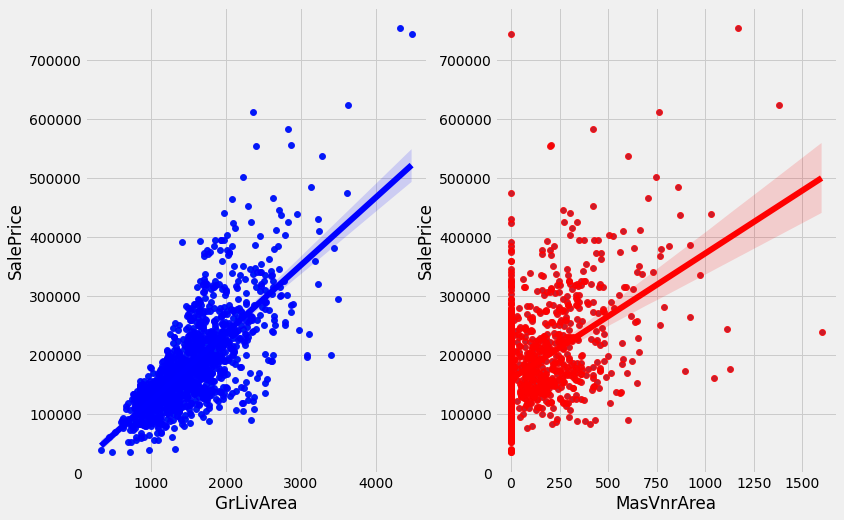

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize = (12, 8), ncols = 2, sharey = False)
sns.scatterplot(x = train_.GrLivArea, y = train_.SalePrice, ax = ax1);
sns.regplot(x = train_.GrLivArea, y = train_.SalePrice, ax = ax1, color = 'b');

sns.scatterplot(x = train_.MasVnrArea, y = train_.SalePrice, ax = ax2);
sns.regplot(x = train_.MasVnrArea, y = train_.SalePrice, ax = ax2, color = 'r');

**Residual plot** tell us how is the error variance across the true line.

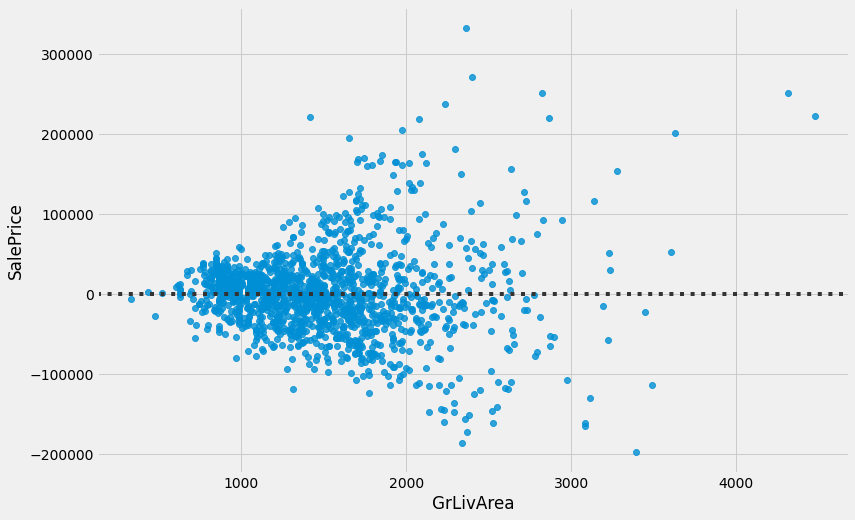

In [ ]:
plt.subplots(figsize = (12, 8))
sns.residplot(train_.GrLivArea, train_.SalePrice);

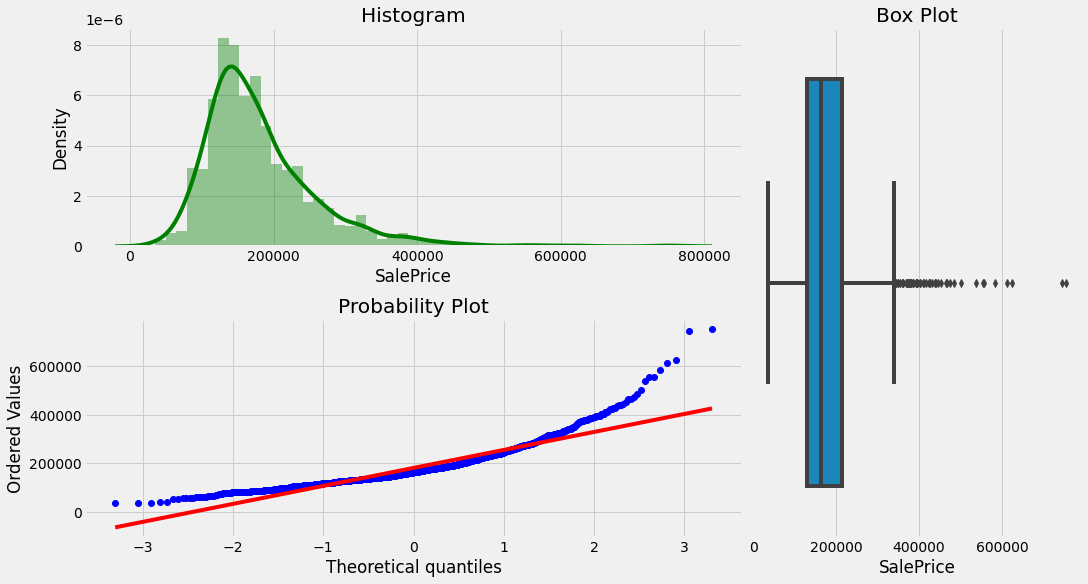

In [ ]:
plotting_3_chart(train_, 'SalePrice')

The reason why outliers was removed was because linear regression analysis was susceptible to outliers.<br>Also, linear regression analysis requires normality. Therefore, we will apply the **log function** to solve these problems.

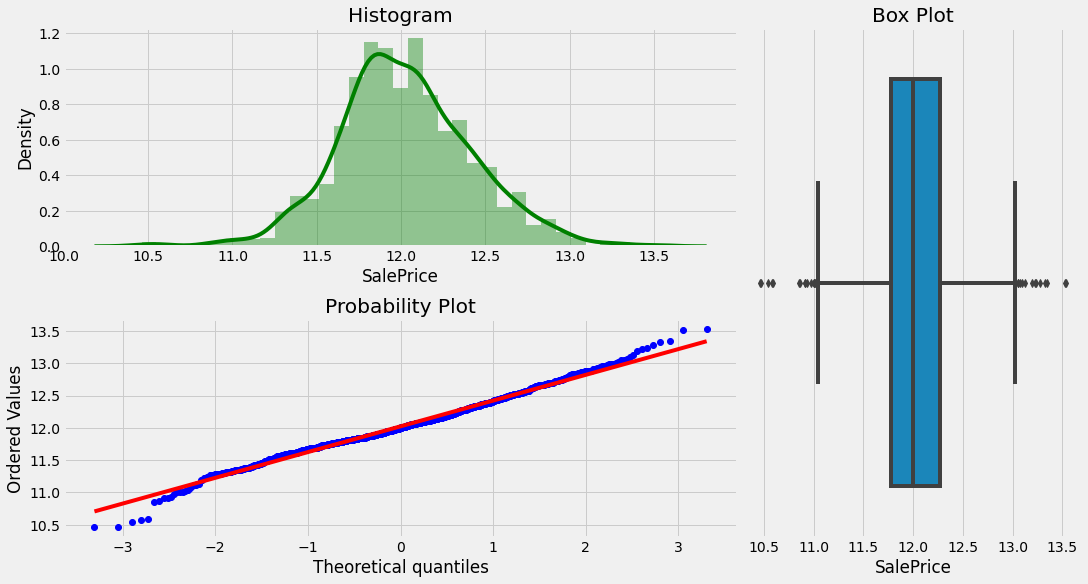

In [ ]:
train_['SalePrice'] = np.log1p(train_['SalePrice'])
plotting_3_chart(train_, 'SalePrice')

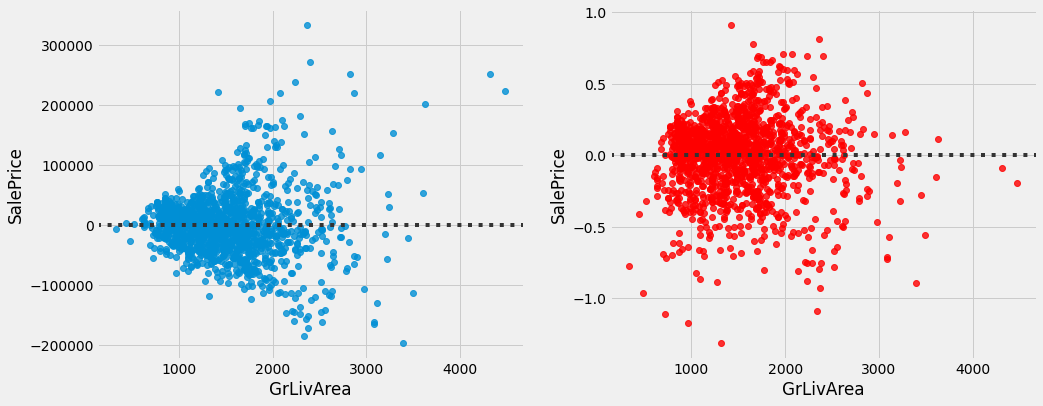

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6), ncols = 2, sharey = False, sharex = False)
sns.residplot(x = previous_train.GrLivArea, y = previous_train.SalePrice, ax = ax1);
sns.residplot(x = train_.GrLivArea, y = train_.SalePrice, ax = ax2, color = 'r');

Wow!<br>Here, we can see that the pre-transformed chart on the left has heteroscedasticity, and the post-transformed chart on the right has homoscedasticity(almost an equal amount of variance across the zero lines).

But problem still remains. The name is **multicollinearity**.<br><br>Multicollinearity is occur when there is a strong correlation between independent variables. Linear regression or multilinear regression requires independent variables to have little or no related features.If there is multicollinearity, the accuracy of analysis will be reduced.<br>So we use Heatmap. this is an excellent way to identify whether there is multicollinearity or not. The best way to solve multicollinearity is to use regularization methods like <a href = '#section_ridge_other'>Ridge or Lasso.</a>

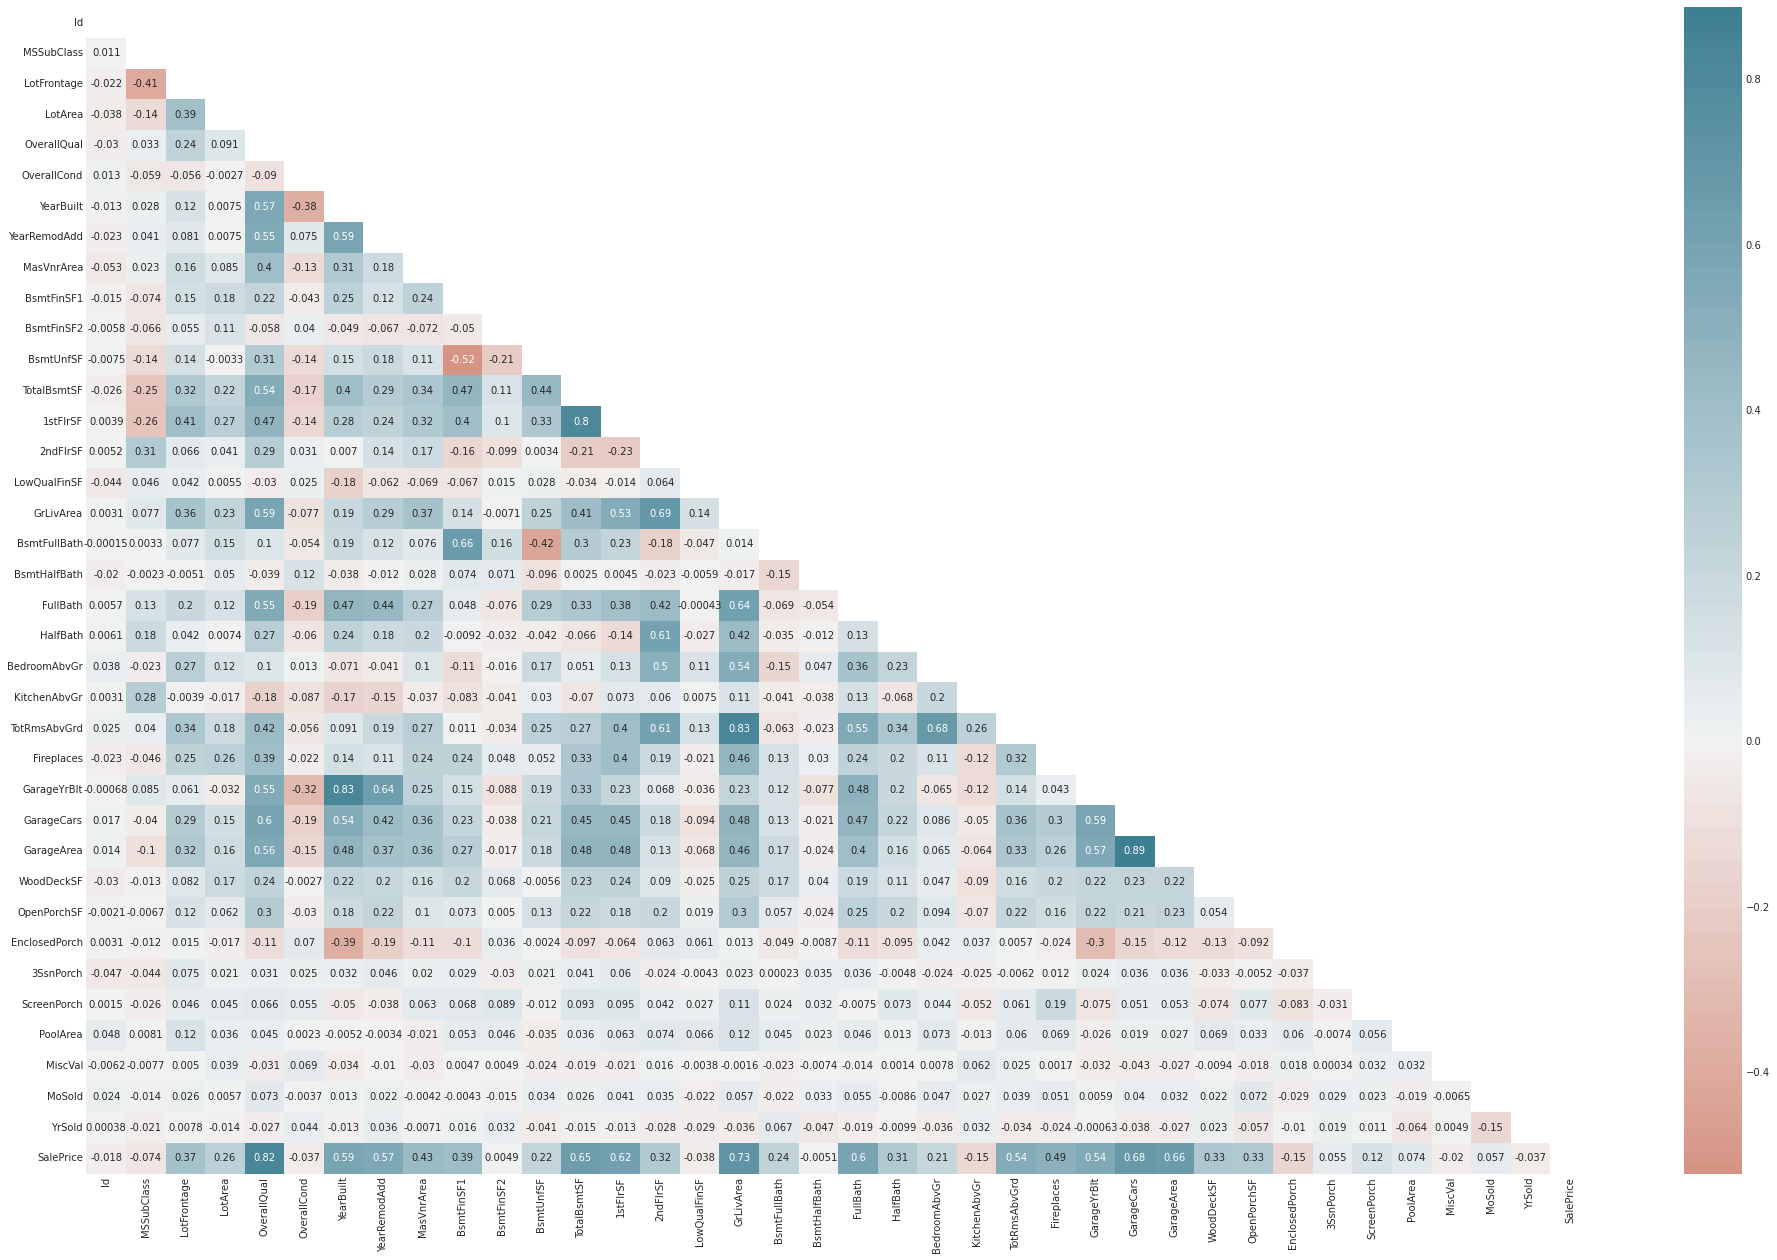

In [ ]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30, 20))

mask = np.zeros_like(train_.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_.corr(),
            cmap = sns.diverging_palette(20, 220, n = 200),
            mask = mask,
            annot = True,
            center = 0);

But this time, we leave these variables for later study. There is algorithms as scikit-learn modules that can give us better outcome.

## Feature engineering

In [ ]:
train_.drop(columns = ['Id'], axis = 1, inplace = True)
test.drop(columns = ['Id'], axis = 1, inplace = True)

In [ ]:
#as y_train
y = train_['SalePrice'].reset_index(drop = True)

In [ ]:
previous_train = train_.copy()

In [ ]:
all_data = pd.concat((train_, test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)

### Dealing with Missing Values

In [ ]:
ratio = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending = False)[(all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending = False) != 0]
total = all_data.isnull().sum().sort_values(ascending = False)[all_data.isnull().sum().sort_values(ascending = False) != 0]
concat_ = pd.concat([total, ratio], axis = 1, keys = ['Total', 'Ratio'])
concat_

,Total,Ratio
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageCond,159,0.054508


In [ ]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
missing_val_col = ["Alley",
                   "PoolQC",
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [ ]:
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath',
                    'BsmtHalfBath',
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

#The mode function returns 'pandas.Series'. Therefore, we use [0] to extract the element.
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0])
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])

In [ ]:
# all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
# all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
# all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)

In [ ]:
if len(all_data.isnull().sum().sort_values(ascending = False)[all_data.isnull().sum().sort_values(ascending = False) != 0]) == 0:
    print('there is no null')

there is no null


In [ ]:
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index
skewed_features = all_data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending = False)
skewed_features

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
GrLivArea         1.068750
LotFrontage       1.058803
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
OverallCond       0.569314
BedroomAbvGr      0.326568
GarageArea        0.216857
MoSold            0.197345
OverallQual       0.189591
FullBath          0.165514
YrSold            0.131996
GarageCars       -0.219297
YearRemodAdd     -0.450134
YearBuilt        -0.599194
GarageYrBlt      -3.904632
dtype: float64

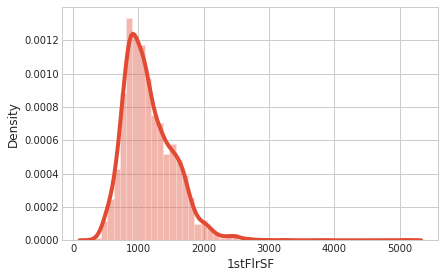

In [ ]:
sns.distplot(all_data['1stFlrSF']);

In [ ]:
## Fixing skewed features using boxcox transformation
def fixing_skewness(df):
    numeric_features = df.dtypes[df.dtypes != 'object'].index

    skewed_features = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending = False)
    high_skew = skewed_features[abs(skewed_features) > 0.5] #abs means absolute value
    skewed_features = high_skew.index

    for feature in skewed_features:
        df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature] + 1))

fixing_skewness(all_data)

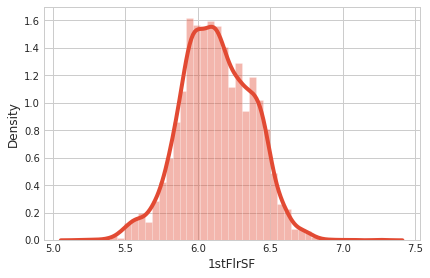

In [ ]:
sns.distplot(all_data['1stFlrSF']);

Compare to the above figure, we can see that skewness has been solved!

### Creating New Features

In [ ]:
all_data['TotalSF'] = (all_data['TotalBsmtSF']
                       + all_data['1stFlrSF']
                       + all_data['2ndFlrSF'])

all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1']
                                 + all_data['BsmtFinSF2']
                                 + all_data['1stFlrSF']
                                 + all_data['2ndFlrSF']
                                )


all_data['Total_Bathrooms'] = (all_data['FullBath']
                               + (0.5 * all_data['HalfBath'])
                               + all_data['BsmtFullBath']
                               + (0.5 * all_data['BsmtHalfBath'])
                              )


all_data['Total_porch_sf'] = (all_data['OpenPorchSF']
                              + all_data['3SsnPorch']
                              + all_data['EnclosedPorch']
                              + all_data['ScreenPorch']
                              + all_data['WoodDeckSF']
                             )

In [ ]:
all_data['hasapool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
all_data.shape

(2917, 89)

### unnecessary feature drop

In [ ]:
drop_features = []
for i in all_data.columns:
    counts = all_data[i].value_counts(ascending = False)
    zeros = counts.iloc[0]
    if zeros / len(all_data) > 0.995:
        print(i)
        drop_features.append(i)

Street
Utilities
PoolArea
PoolQC
hasapool


In [ ]:
all_data = all_data.drop(drop_features, axis = 1)

In [ ]:
all_data.shape

(2917, 84)

In [ ]:
feature_candidates = pd.get_dummies(all_data).reset_index(drop = True)
print(feature_candidates.head(5))

   LotFrontage    LotArea  OverallQual  OverallCond     YearBuilt  \
0    18.780786  13.833054            7     3.991517  2.737606e+51   
1    21.443061  14.117918            6     6.000033  2.205231e+51   
2    19.331294  14.476512            7     3.991517  2.694373e+51   
3    17.840337  14.106196            7     3.991517  1.338013e+51   
4    22.118472  15.022008            8     3.991517  2.672997e+51   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
0          2003   19.433175  144.117862         0.0  29.991055  ...   
1          1976    0.000000  181.719186         0.0  44.135415  ...   
2          2002   17.768840  110.441033         0.0  56.896536  ...   
3          1970    0.000000   61.795315         0.0  64.808858  ...   
4          2000   25.404164  136.624601         0.0  61.166379  ...   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0   

In [ ]:
X = feature_candidates.iloc[:len(y), :]
X_sub = feature_candidates.iloc[len(y):, :]

In [ ]:
print(X.shape, X_sub.shape)

(1458, 316) (1459, 316)


In [ ]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(X)

In [ ]:
X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

In [ ]:
X.shape, y.shape, X_sub.shape

((1458, 315), (1458,), (1459, 315))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((976, 315), (482, 315), (976,), (482,))

## Modeling the Data

First, let's check the variance of SalePrice and GrLivArea, these are correlated with each other as you can see above.

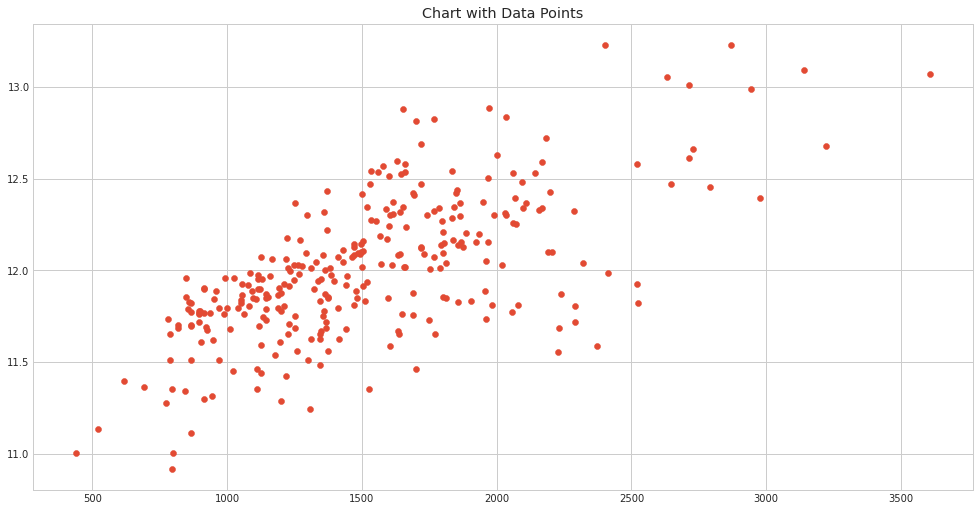

In [ ]:
sample_train = previous_train.sample(300)
plt.subplots(figsize = (15, 8))
ax = plt.gca()
ax.scatter(sample_train.GrLivArea.values, sample_train.SalePrice.values);
plt.title('Chart with Data Points');

What happens if we take the average of the data points?

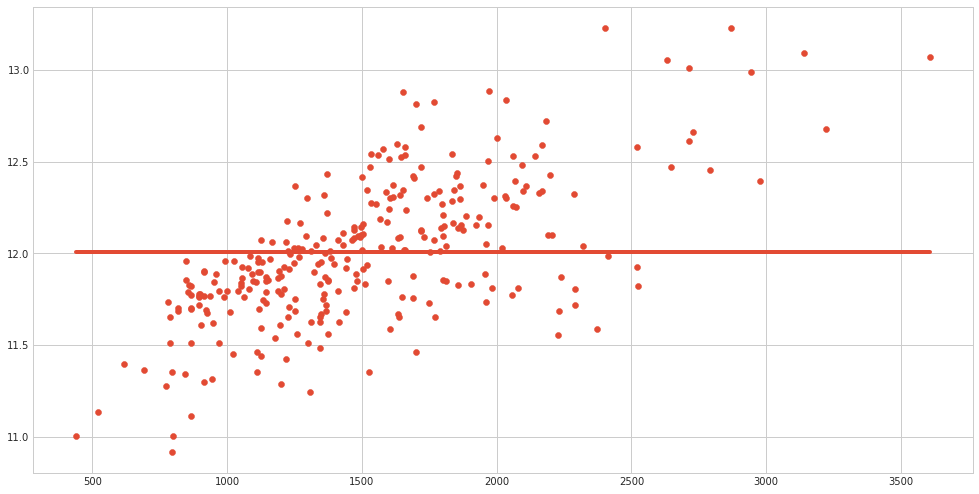

In [ ]:
plt.subplots(figsize = (15, 8))
ax = plt.gca()
ax.scatter(sample_train.GrLivArea.values, sample_train.SalePrice.values);
ax.plot((sample_train.GrLivArea.values.min(), sample_train.GrLivArea.values.max()), (sample_train.SalePrice.values.mean(), sample_train.SalePrice.values.mean()));

This way is the most efficient way to estimate the price of houses. But this doesn't represent all datapoint trend.<br>So, we use **MSE**.

In [ ]:
sample_train['mean_sale_price'] = sample_train.SalePrice.mean()
sample_train['mse'] = np.square(sample_train.mean_sale_price - sample_train.SalePrice)
sample_train.mse.mean()# this is mse. the closer this value of MSE is to 0, the better.

0.1507565605753039

The detail of MSE is [here](https://towardsdatascience.com/https-medium-com-chayankathuria-regression-why-mean-square-error-a8cad2a1c96f). <br>In a nutshell, the closer the value of MSE is to "0", the better. We want to minimize this error. In the process of reducing MSE, we use the powerful model, **Linear Regression**.

### $$ y = \beta_0 + \beta_1 x + \epsilon \\ $$
<hr>

##### $$ \hat{\beta}_1 = r_{xy} \frac{s_y}{s_x}$$
##### $$ \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x} $$
##### $$ r_{xy}= \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum(x_i - \bar{x})^2{\sum(y_i - \bar{y})^2}}}$$
<br>Here...
- $\bar{y}$ : the sample mean of observed values $Y$
- $\bar{x}$ : the sample mean of observed values $X$
- $s_y$ : the sample standard deviation of observed values $Y$
- $s_x$ : the sample standard deviation of observed values $X$
- $ \epsilon$ : error or residual. In above figure, the distance of datapoint and redline.

In [ ]:
y_bar = sample_train.SalePrice.mean()
x_bar = sample_train.GrLivArea.mean()
std_y = sample_train.SalePrice.std()
std_x = sample_train.GrLivArea.std()
r_xy = sample_train.corr().loc['GrLivArea', 'SalePrice']#pearson correlation coefficient 相関係数

In [ ]:
beta_1 = r_xy * (std_y / std_x)
beta_0 = y_bar - beta_1 * x_bar

sample_train['Linear_Yhat'] = beta_0 + beta_1 * sample_train['GrLivArea']

In [ ]:
sample_train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,mean_sale_price,mse,Linear_Yhat
526,60,RL,67.0,14948,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,0,11,2008,New,Partial,13.008662,12.005037,1.007262,12.617959
968,190,RL,75.0,10382,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,3,2006,ConLD,Normal,11.849405,12.005037,0.024221,11.786845
1227,120,RL,65.0,8769,Pave,NaN,Reg,Lvl,AllPub,Corner,...,NaN,0,10,2008,New,Partial,12.813921,12.005037,0.654292,12.098641
54,80,RL,60.0,7134,Pave,NaN,Reg,Bnk,AllPub,Inside,...,NaN,0,2,2007,WD,Normal,11.775297,12.005037,0.052780,11.922967
1287,120,RL,40.0,5664,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,0,10,2009,WD,Normal,12.535380,12.005037,0.281263,12.076553
1382,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,10,2009,WD,Normal,11.561725,12.005037,0.196526,11.870573
1454,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,2,2010,WD,Normal,12.254868,12.005037,0.062415,12.289212
1449,20,RL,78.0,9262,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,5,2009,New,Partial,12.567555,12.005037,0.316426,12.034946
627,60,RL,70.0,11606,Pave,NaN,IR1,HLS,AllPub,Inside,...,NaN,0,9,2007,WD,Family,11.813037,12.005037,0.036864,12.292808
695,30,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,6,2006,WD,Normal,11.396403,12.005037,0.370436,11.540798


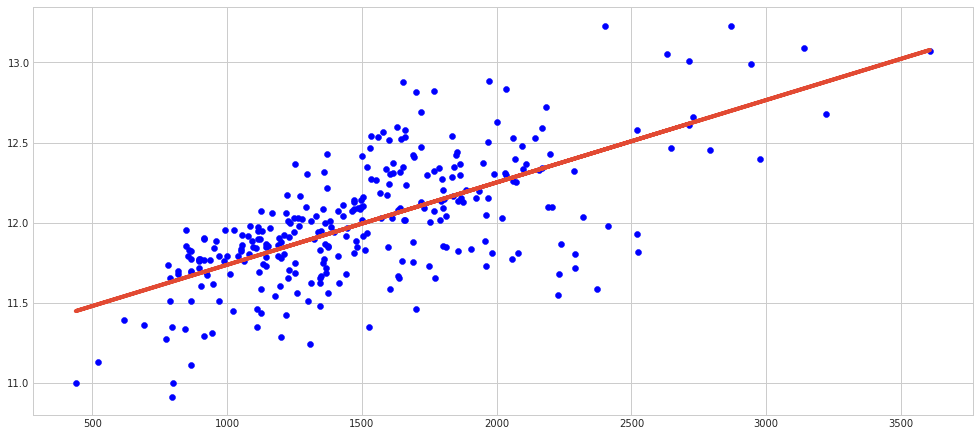

In [ ]:
fig = plt.figure(figsize = (15, 7))
ax = plt.gca()

ax.scatter(sample_train.GrLivArea, sample_train.SalePrice, c = 'b');
ax.plot(sample_train.GrLivArea, sample_train.Linear_Yhat);

In [ ]:
print('mean squared error for regression line is {}'.format(np.square(sample_train['SalePrice'] - sample_train['Linear_Yhat']).mean()))
# print('mean squared error for regression line is {}'.format(mean_squared_error(sample_train['SalePrice'], sample_train['Linear_Yhat'])))

mean squared error for regression line is 0.08297843284900404


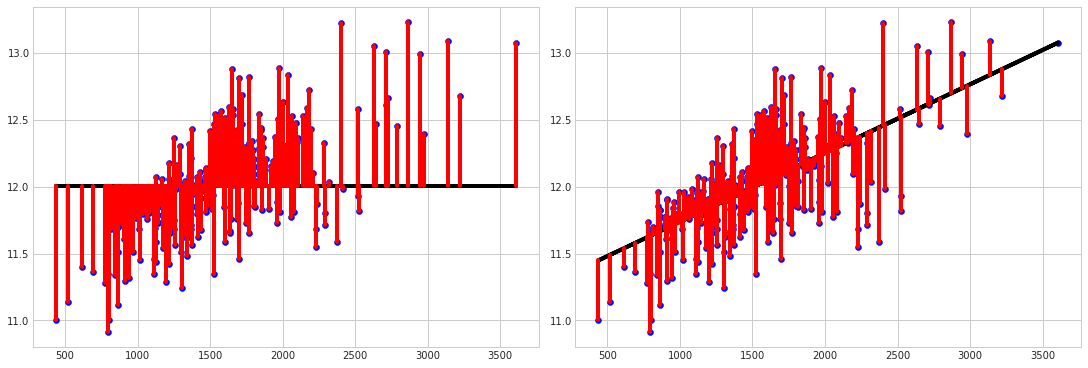

In [ ]:
fig = plt.figure(constrained_layout = True, figsize = (15, 5))
grid = gridspec.GridSpec(ncols = 2, nrows = 1, figure = fig)
ax1 = fig.add_subplot(grid[0, :1])

# ax1 = fig.gca()
ax1.scatter(x = sample_train['GrLivArea'], y = sample_train['SalePrice'], c = 'b');
ax1.plot(sample_train['GrLivArea'], sample_train['mean_sale_price'], color = 'k');

for _, row in sample_train.iterrows():
    plt.plot((row['GrLivArea'], row['GrLivArea']), (row['SalePrice'], row['mean_sale_price']), 'r-')


ax2 = fig.add_subplot(grid[0, 1:])
ax2.scatter(x = sample_train['GrLivArea'], y = sample_train['SalePrice'], c = 'b');
ax2.plot(sample_train['GrLivArea'], sample_train['Linear_Yhat'], color = 'k');

for _, row in sample_train.iterrows():
    plt.plot((row['GrLivArea'], row['GrLivArea']), (row['SalePrice'], row['Linear_Yhat']), 'r-')

This makes it obvious.<br>The MSE is getting smaller and close to its goal. Now, let's actually try to predict the SalePrice using **Linear Legression**.<br>This time, we have two features for simplicity. If there is more than one variable, it will look like this,
### $$ \hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n $$
Conveniently, the library is ready to go. We have to be grateful for this.

In [ ]:
lin_reg = LinearRegression(normalize = True, n_jobs = -1)
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [ ]:
print('%.2f'%mean_squared_error(y_test, y_pred))

109470110494871433248768.00


In [ ]:
lin_reg = LinearRegression()
cv = KFold(shuffle = True, random_state = 2, n_splits = 10)
scores = cross_val_score(lin_reg, X, y, cv = cv, scoring = 'neg_mean_absolute_error')

In [ ]:
print('%.8f'%scores.mean())

-0.27505477


Above we've seen is the simplest way to construct the model. However, there are more complex regression, so let's dive deep into some of it.

<a id = 'section_ridge_other'></a>
## Regularization Models

What makes regressionmodel more effective is its ability of regularizing. *Regularization* is the ability to structurally prevent overfitting by imposing a penalty on the coefficients.

There are three types of regularizations.
<ul>
<li>Ridge
<li>Lasso
<li>Elastic Net
</ul>

### <b>Ridge</b><br>

### $$ \text{minimize:}\; RSS+Ridge = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_2\sum_{j=1}^p \beta_j^2$$<br>
One of the benefits of regularization of using *Ridge* is that it deals with **multicollinearity**(high correlation between predictor variables) well especially.<br>(Lasso deals with multicollinearity more brutally by penalizing related coefficient and force them to become zero, hence removing them.)<br>We have some points we need to be aware of.
<ul>
<li>It is essential to standardize the predictor variables before constructing the models.
<li>It is important to chec for multicollinearity.
</ul>

In [ ]:
alpha_ridge = [-3,-2,-1,1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
temp_rss = {}
temp_mse = {}

for i in alpha_ridge:
    ridge = Ridge(alpha = i, normalize = True)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    temp_mse[i] = mse

    rss = sum((y_pred - y_test) ** 2)
    temp_rss[i] = rss

In [ ]:
for key, value in sorted(temp_mse.items(), key = lambda item: item[1]):
    print("%s: %s" % (key, value))

0.5: 0.013655779119779764
1: 0.014669202521287476
0.01: 0.015323754394125996
1.5: 0.015847646941201055
0.001: 0.016880270348363292
2: 0.017073889726889908
0.0001: 0.017437494741701132
1e-05: 0.01750897795921654
1e-08: 0.017517139309263675
1e-10: 0.017517149281389283
1e-15: 0.017518177055226365
3: 0.01958804183602498
4: 0.0221416860111623
5: 0.024706746250705666
10: 0.03715655891390629
20: 0.058096205394687656
30: 0.07382860998390235
40: 0.08574792515446576
-2: 1.3956134397789015
-1: 13.818490332846071
-3: 198.218757813067


In [ ]:
for key, value in sorted(temp_rss.items(), key = lambda item: item[1]):
    print("%s: %s" % (key, value))

0.5: 6.582085535733839
1: 7.070555615260553
0.01: 7.386049617968734
1.5: 7.638565825658911
0.001: 8.136290307911104
2: 8.22961484836093
0.0001: 8.40487246549995
1e-05: 8.43932737634238
1e-08: 8.443261147065089
1e-10: 8.443265953629634
1e-15: 8.44376134061911
3: 9.441436164964038
4: 10.672292657380218
5: 11.90865169284014
10: 17.909461396502834
20: 28.002371000239453
30: 35.58539001224093
40: 41.33049992445253
-2: 672.6856779734303
-1: 6660.512340431807
-3: 95541.44126589822


In [ ]:
temp_rss_ = {}
temp_mse_ = {}

for i in alpha_ridge:
    lasso_reg = Lasso(alpha = i, normalize = True)
    lasso_reg.fit(X_train, y_train)
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    temp_mse_[i] = mse

    rss = sum((y_pred - y_test) ** 2)
    temp_rss_[i] = rss

### <b>Lasso</b>

    
### $$ \text{minimize:}\; RSS + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j|$$

In [ ]:
temp_rss_ = {}
temp_mse_ = {}

for i in alpha_ridge:
    lasso_reg = Lasso(alpha = i, normalize = True)
    lasso_reg.fit(X_train, y_train)
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    temp_mse_[i] = mse

    rss = sum((y_pred - y_test) ** 2)
    temp_rss_[i] = rss

In [ ]:
for key, value in sorted(temp_mse_.items(), key = lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 0.012299230952897137
1e-05: 0.01460926327904015
0.001: 0.01744079253541274
1e-15: 0.017493012810028644
1e-10: 0.01749309039136884
1e-08: 0.017495675666808083
0.01: 0.1581846960855483
0.5: 0.16467335518379542
1: 0.16467335518379542
1.5: 0.16467335518379542
2: 0.16467335518379542
3: 0.16467335518379542
4: 0.16467335518379542
5: 0.16467335518379542
10: 0.16467335518379542
20: 0.16467335518379542
30: 0.16467335518379542
40: 0.16467335518379542
-1: 6289358969.354252
-2: 25157442883.613873
-3: 56604251742.79627


In [ ]:
for key, value in sorted(temp_rss_.items(), key = lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 5.928229319296419
1e-05: 7.041664900497351
0.001: 8.406462002068931
1e-15: 8.431632174433805
1e-10: 8.431669568639787
1e-08: 8.432915671401492
0.01: 76.24502351323439
0.5: 79.37255719858955
1: 79.37255719858955
1.5: 79.37255719858955
2: 79.37255719858955
3: 79.37255719858955
4: 79.37255719858955
5: 79.37255719858955
10: 79.37255719858955
20: 79.37255719858955
30: 79.37255719858955
40: 79.37255719858955
-1: 3031471023228.748
-2: 12125887469901.893
-3: 27283249340027.81


### <b>Elastic Net</b>
Elastic Net is the combination of both Ridge and Lasso.<br>
### $$ \text{minimize:}\; RSS + Ridge + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j| + \lambda_2\sum_{j=1}^p \beta_j^2$$

In [ ]:
_temp_rss = {}
_temp_mse = {}

for i in alpha_ridge:
    lasso_reg = ElasticNet(alpha = i, normalize = True)
    lasso_reg.fit(X_train, y_train)
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    _temp_mse[i] = mse

    rss = sum((y_pred - y_test) ** 2)
    _temp_rss[i] = rss

In [ ]:
for key, value in sorted(_temp_mse.items(), key = lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 0.012598325591077647
1e-05: 0.0149261023134917
0.001: 0.015358826358502511
1e-08: 0.017490852806509603
1e-15: 0.01749301280929196
1e-10: 0.017493016726746885
0.01: 0.10668946202832924
0.5: 0.16467335518379542
1: 0.16467335518379542
1.5: 0.16467335518379542
2: 0.16467335518379542
3: 0.16467335518379542
4: 0.16467335518379542
5: 0.16467335518379542
10: 0.16467335518379542
20: 0.16467335518379542
30: 0.16467335518379542
40: 0.16467335518379542
-3: 5.719915733345539
-2: 5.805970604885633
-1: 6.076485792565941


In [ ]:
for key, value in sorted(_temp_rss.items(), key = lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 6.0723929348994234
1e-05: 7.194381315103004
0.001: 7.402954304798209
1e-08: 8.430591052737643
1e-15: 8.431632174078729
1e-10: 8.431634062291996
0.01: 51.42432069765476
0.5: 79.37255719858955
1: 79.37255719858955
1.5: 79.37255719858955
2: 79.37255719858955
3: 79.37255719858955
4: 79.37255719858955
5: 79.37255719858955
10: 79.37255719858955
20: 79.37255719858955
30: 79.37255719858955
40: 79.37255719858955
-3: 2756.999383472547
-2: 2798.4778315548756
-1: 2928.86615201678


In [ ]:
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = (0.01, 1e-05, 1e-02), cv = kfolds))#The larger the alphas, the stronger the regularization.
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter = 1e7, alphas = (0.01, 1e-05, 1e-02), random_state = 42, cv = kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter = 1e7, alphas = (0.01, 0.01, 1), cv = kfolds))
svr = make_pipeline(RobustScaler(), SVR(C = 20, epsilon = 0.008, gamma = 'auto'))

In [ ]:
'''
gbr = GradientBoostingRegressor(n_estimators = 3000,
                                learning_rate = 0.05,
                                max_depth = 4,
                                max_features = 'sqrt',
                                min_samples_leaf = 15,
                                min_samples_split = 10,
                                loss = 'huber',
                                random_state = 42)
                                '''

"\ngbr = GradientBoostingRegressor(n_estimators = 3000,\n                                learning_rate = 0.05, \n                                max_depth = 4, \n                                max_features = 'sqrt', \n                                min_samples_leaf = 15, \n                                min_samples_split = 10, \n                                loss = 'huber',\n                                random_state = 42)\n                                "

In [ ]:
lightgbm = LGBMRegressor(objective = 'regression',
                         num_leaves = 4,
                         learning_rate = 0.01,
                         n_estimators = 5000,
                         max_bin = 200,
                         bagging_fraction = 0.75,
                         bagging_freq = 5,
                         bagging_seed = 7,
                         feature_fraction = 0.2,
                         feature_fraction_seed = 7,
                         verbose = -1)

In [ ]:
'''xgboost = xg.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)'''

"xgboost = xg.XGBRegressor(learning_rate=0.01,n_estimators=3460,\n                                     max_depth=3, min_child_weight=0,\n                                     gamma=0, subsample=0.7,\n                                     colsample_bytree=0.7,\n                                     objective='reg:linear', nthread=-1,\n                                     scale_pos_weight=1, seed=27,\n                                     reg_alpha=0.00006)"

In [ ]:
'''stack_gen = StackingCVRegressor(regressors = (ridge, lasso, elasticnet, lightgbm),
                                meta_regressor = lightgbm,
                                use_features_in_secondary = True)'''

'stack_gen = StackingCVRegressor(regressors = (ridge, lasso, elasticnet, lightgbm), \n                                meta_regressor = lightgbm,\n                                use_features_in_secondary = True)'

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfolds))
    return rmse

In [ ]:
score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = cv_rmse(gbr)
# print("gradient_boosting_regressor: {:.4f} ({:.4f})".format(score.mean(), score.std()))

# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge: 0.1262 (0.0164)

Lasso: 0.1288 (0.0173)

elastic net: 0.1236 (0.0193)

SVR: 0.1210 (0.0157)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignor

In [ ]:
# score = cv_rmse(stack_gen)
# print("stacking_cv_legressor: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
elastic_model_full_data = elasticnet.fit(X_train, y_train)
lasso_model_full_data = lasso.fit(X_train, y_train)
ridge_model_full_data = ridge.fit(X_train, y_train)
svr_model_full_data = svr.fit(X_train, y_train)
lgb_model_full_data = lightgbm.fit(X_train, y_train)
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


In [ ]:
# abc

In [ ]:
def blend_models_predict(X):
    return (
        (0.2 * elastic_model_full_data.predict(X)) + \
        (0.2 * lasso_model_full_data.predict(X)) + \
        (0.2 * ridge_model_full_data.predict(X)) + \
        (0.2 * svr_model_full_data.predict(X)) + \
        (0.2 * lgb_model_full_data.predict(X))# + \
#         (0.1 * stack_gen_model.predict(np.array(X)))
    )

In [ ]:
print("RMSLE score on train data: ", rmsle(y, blend_models_predict(X)))

RMSLE score on train data:  0.0839154089638591


In [ ]:
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:, 1] = np.floor(np.expm1(blend_models_predict(X_sub)))

In [ ]:
submission.to_csv("submission.csv", index = False)

In [ ]:
submission

,Id,SalePrice
0,1461,126279.0
1,1462,160512.0
2,1463,189299.0
3,1464,196745.0
4,1465,189206.0
...,...,...
1454,2915,84930.0
1455,2916,79925.0
1456,2917,176668.0
1457,2918,117823.0


## Thank you!!!

If you find this notebook useful, please **upvote**!
<br>And if you have any questions, please ask on the **comments**!


## Other Work( please **upvote**＜(_ _)＞ )

* [The power of normality and visualization
](https://www.kaggle.com/fightingmuscle/the-power-of-normality-and-visualization)
* [【Over 0.8!】Titanic_more_technical_EDA(ENG&JPN)](https://www.kaggle.com/fightingmuscle/over-0-8-titanic-more-technical-eda-eng-jpn)

> These notebooks were put together by me as a beginner, so I believe anyone can learn from them!

* [How did I get the silver medal?(0.717)【Infer】](https://www.kaggle.com/fightingmuscle/how-did-i-get-the-silver-medal-0-717-infer/comments)

> I got silver medal for the first time! I published my inference code and trained models. My training code will be available soon, please wait.